In [1]:
import pandas as pd
import numpy as np
import simpy
import random
menu_df = pd.read_csv('menu.csv')
menu_df

,ID,Item,Price,Margin,Gross Profit Per Item,Popularity,Prep_Time
0,1,847 Burger Half-Pound,$8.00,70%,$5.60,5,0.50
1,2,847 Burger Full-Pound,$10.00,70%,$7.00,4,1.00
2,3,Milkshake Small,$5.00,80%,$4.00,2,1.50
3,4,Milkshake Large,$7.00,80%,$5.60,3,2.00
4,5,Drink Small,$3.00,90%,$2.70,3,0.50
5,6,Drink Large,$4.00,90%,$3.60,4,0.75
6,7,Fries Small,$4.00,70%,$2.80,5,0.50
7,8,Fries Large,$7.00,70%,$4.90,3,1.00
8,9,Ice Cream,$9.00,85%,$7.65,1,2.00
9,10,Peanuts,$3.00,80%,$2.40,2,0.25


In [10]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

PERCENT_SUBSCRIBERS = 0.10  # Percentage of customers who are subscribers
PREMIUM_MEMBERSHIP_PRICE = 20  # Adjustable premium membership price
NUM_CUSTOMERS = 5000  # Total number of unique customers in the customer base


customer_ids = range(1, NUM_CUSTOMERS + 1)
is_subscriber = np.random.rand(NUM_CUSTOMERS) < PERCENT_SUBSCRIBERS
price_tolerance = np.random.normal(15, 2, NUM_CUSTOMERS)  # Normal dist with mean 20 and std 5
customer_base_df = pd.DataFrame({
    'CustomerID': customer_ids, 
    'IsSubscriber': is_subscriber,
    'PriceTolerance': price_tolerance
})
customer_base_df.to_csv('customer_base.csv', index=False)
customer_base_df

,CustomerID,IsSubscriber,PriceTolerance
0,1,False,13.806051
1,2,False,10.219391
2,3,False,14.175559
3,4,False,16.826947
4,5,False,16.075260
...,...,...,...
4995,4996,False,19.481853
4996,4997,False,15.952860
4997,4998,False,14.693479
4998,4999,False,17.830409


In [6]:

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

DAYS_IN_SIMULATION = 30 * 2
SIMULATION_TIME_PER_DAY = 8 * 60  # 8 hours per day in minutes
ARRIVAL_RATE = 1  # Average time between arrivals
MAX_QUEUE_LENGTH_REGULAR = 5  # Maximum queue length before regular customers start balking
MAX_QUEUE_LENGTH_IMPATIENT = 3  # Maximum queue length for impatient customers
RENEGING_TIME_REGULAR = 8  # Time after which a regular customer may renege
RENEGING_TIME_IMPATIENT = 3  # Time for impatient customers
IMPATIENCE_PROBABILITY = 0.15  # Probability that a customer is impatient on a given visit

customer_records = []

def choose_items(menu, num_items):
    chosen_items = random.choices(menu['ID'], weights=menu['Popularity'], k=num_items)
    return chosen_items

class Customer:
    def __init__(self, env, customer_id, queue, queue_name, day, is_subscriber, is_impatient):
        self.env = env
        self.customer_id = customer_id
        self.queue = queue
        self.queue_name = queue_name
        self.day = day
        self.is_subscriber = is_subscriber
        self.is_impatient = is_impatient

    def order(self):
        num_items_ordered = max(1, min(8, int(np.random.normal(3, 1))))
        ordered_items = choose_items(menu_df, num_items_ordered)
        total_prep_time = sum(menu_df[menu_df['ID'].isin(ordered_items)]['Prep_Time'])
        max_queue_length = MAX_QUEUE_LENGTH_IMPATIENT if self.is_impatient else MAX_QUEUE_LENGTH_REGULAR
        reneging_time = RENEGING_TIME_IMPATIENT if self.is_impatient else RENEGING_TIME_REGULAR

        record = {
            'customer_id': self.customer_id,
            'is_subscriber': self.is_subscriber,
            'is_impatient': self.is_impatient,
            'queue_name': self.queue_name,
            'day': self.day,
            'arrival_time': self.env.now,
            'num_items_ordered': num_items_ordered
        }

        for i in range(1, 8):
            record[f'item{i}'] = ordered_items[i - 1] if i <= len(ordered_items) else None

        with self.queue.request() as request:
            if len(self.queue.queue) > max_queue_length:
                record['action'] = 'balked'
                customer_records.append(record)
                return

            yield request | self.env.timeout(reneging_time)
            yield self.env.timeout(total_prep_time)

            record['departure_time'] = self.env.now
            record['action'] = 'served'
            customer_records.append(record)

def burger_shop(env, regular_queue, premium_queue, day, customer_base, premium_price):
    while True:
        arrival_interval = random.expovariate(1.0 / ARRIVAL_RATE)
        yield env.timeout(arrival_interval)

        selected_customer = customer_base.sample(1).iloc[0]
        customer_id = selected_customer['CustomerID']
        price_tolerance = selected_customer['PriceTolerance']
        is_subscriber = selected_customer['IsSubscriber'] or (price_tolerance >= premium_price)

        is_impatient = random.random() < IMPATIENCE_PROBABILITY
        queue = premium_queue if is_subscriber else regular_queue
        queue_name = 'premium_queue' if is_subscriber else 'regular_queue'

        customer = Customer(env, customer_id, queue, queue_name, day, is_subscriber, is_impatient)
        env.process(customer.order())

for day in range(1, DAYS_IN_SIMULATION + 1):
    env = simpy.Environment()
    regular_queue = simpy.Resource(env, capacity=1)
    premium_queue = simpy.Resource(env, capacity=1)
    env.process(burger_shop(env, regular_queue, premium_queue, day, customer_base_df, PREMIUM_MEMBERSHIP_PRICE))
    env.run(until=SIMULATION_TIME_PER_DAY)

df = pd.DataFrame(customer_records)

df['wait_time'] = df['departure_time'] - df['arrival_time']
df

,customer_id,is_subscriber,is_impatient,queue_name,day,arrival_time,num_items_ordered,item1,item2,item3,item4,item5,item6,item7,departure_time,action,wait_time
0,1502,False,True,regular_queue,1,1.020060,4,2,7.0,7.0,8.0,NaN,NaN,NaN,3.520060,served,2.500000
1,483,False,True,regular_queue,1,1.341684,3,1,2.0,5.0,NaN,NaN,NaN,NaN,5.520060,served,4.178376
2,3903,True,False,premium_queue,1,3.769160,2,3,1.0,NaN,NaN,NaN,NaN,NaN,5.769160,served,2.000000
3,1106,False,True,regular_queue,1,1.889731,3,6,6.0,2.0,NaN,NaN,NaN,NaN,6.639731,served,4.750000
4,3827,False,False,regular_queue,1,2.111422,1,1,NaN,NaN,NaN,NaN,NaN,NaN,7.139731,served,5.028308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28597,1240,False,False,regular_queue,60,465.635961,4,8,2.0,5.0,10.0,NaN,NaN,NaN,476.385961,served,10.750000
28598,2340,False,False,regular_queue,60,467.981630,3,5,5.0,10.0,NaN,NaN,NaN,NaN,476.731630,served,8.750000
28599,4933,False,False,regular_queue,60,468.575437,2,6,1.0,NaN,NaN,NaN,NaN,NaN,477.825437,served,9.250000
28600,950,False,False,regular_queue,60,474.314247,1,1,NaN,NaN,NaN,NaN,NaN,NaN,478.325437,served,4.011190


In [7]:
df.groupby(['is_subscriber', 'is_impatient', 'queue_name', 'action'])[['action']].count()

action
is_subscriber is_impatient queue_name    action        
False         False        regular_queue balked       3
                                         served    2743
              True         regular_queue balked       4
                                         served     490
True          False        premium_queue balked       7
                                         served    3356
              True         premium_queue balked      15
                                         served     548

In [11]:
def calculate_profit(row, menu):
    total_profit = 0.0
    for i in range(1, 8): 
        item_id = row[f'item{i}']
        if item_id!=0:
            profit = menu.loc[menu['ID'] == item_id, 'Gross Profit Per Item'].values[0]
            total_profit += profit
    return total_profit

In [14]:
for i in range(1, 8):
    df[f'item{i}'] = df[f'item{i}'].fillna(0).astype(int)

try:
    menu_df['Gross Profit Per Item']=pd.to_numeric(menu_df['Gross Profit Per Item'].str.replace('$',''))
except:
    pass
def calculate_profit(row, menu):
    total_profit = 0.0
    for i in range(1, 8): 
        item_id = row[f'item{i}']
        if item_id!=0:
            profit = menu.loc[menu['ID'] == item_id, 'Gross Profit Per Item'].values[0]
            total_profit += profit
    return total_profit

# df['profit'] = df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
df.to_csv("simulation.csv")
df

,customer_id,is_subscriber,is_impatient,queue_name,day,arrival_time,num_items_ordered,item1,item2,item3,item4,item5,item6,item7,departure_time,action,wait_time
0,1502,False,True,regular_queue,1,1.020060,4,2,7,7,8,0,0,0,3.520060,served,2.500000
1,483,False,True,regular_queue,1,1.341684,3,1,2,5,0,0,0,0,5.520060,served,4.178376
2,3903,True,False,premium_queue,1,3.769160,2,3,1,0,0,0,0,0,5.769160,served,2.000000
3,1106,False,True,regular_queue,1,1.889731,3,6,6,2,0,0,0,0,6.639731,served,4.750000
4,3827,False,False,regular_queue,1,2.111422,1,1,0,0,0,0,0,0,7.139731,served,5.028308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28597,1240,False,False,regular_queue,60,465.635961,4,8,2,5,10,0,0,0,476.385961,served,10.750000
28598,2340,False,False,regular_queue,60,467.981630,3,5,5,10,0,0,0,0,476.731630,served,8.750000
28599,4933,False,False,regular_queue,60,468.575437,2,6,1,0,0,0,0,0,477.825437,served,9.250000
28600,950,False,False,regular_queue,60,474.314247,1,1,0,0,0,0,0,0,478.325437,served,4.011190


In [8]:
from scipy.optimize import minimize
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

def burger_shop(env, regular_queue, premium_queue, day, customer_base, premium_price):
    while True:
        arrival_interval = random.expovariate(1.0 / ARRIVAL_RATE)
        yield env.timeout(arrival_interval)

        selected_customer = customer_base.sample(1).iloc[0]
        customer_id = selected_customer['CustomerID']
        is_impatient = random.random() < IMPATIENCE_PROBABILITY
        price_tolerance = selected_customer['PriceTolerance']
        is_subscriber = selected_customer['IsSubscriber'] or (price_tolerance >= premium_price)

        queue = premium_queue if is_subscriber else regular_queue
        queue_name = 'premium_queue' if is_subscriber else 'regular_queue'

        customer = Customer(env, customer_id, queue, queue_name, day, is_subscriber, is_impatient)
        env.process(customer.order())

def run_simulation_for_price(premium_price, customer_base_df):
    global customer_records
    customer_records = []

    for day in range(1, DAYS_IN_SIMULATION + 1):
        env = simpy.Environment()
        regular_queue = simpy.Resource(env, capacity=1)
        premium_queue = simpy.Resource(env, capacity=1)
        env.process(burger_shop(env, regular_queue, premium_queue, day, customer_base_df, premium_price))
        env.run(until=SIMULATION_TIME_PER_DAY)

    simulation_df = pd.DataFrame(customer_records)
    for i in range(1, 8):
        simulation_df[f'item{i}'] = simulation_df[f'item{i}'].fillna(0).astype(int)
    simulation_df['profit'] = simulation_df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
    profit_per_subscriber = premium_price
    sub_profit = simulation_df[simulation_df['is_subscriber']]['customer_id'].nunique() * profit_per_subscriber
    food_profit=simulation_df['profit'].sum()
    total_profit=sub_profit+food_profit
    return total_profit

def optimize_membership_price(customer_base_df):
    def objective_function(price):
        return -run_simulation_for_price(price[0], customer_base_df)

    bounds = [(5.00, 50.00)] 

    initial_guess = [18.00]

    result = minimize(objective_function, initial_guess, bounds=bounds)

    return result, result.x[0]

# full_results, optimal_price = optimize_membership_price(customer_base_df)
# print(f"Optimal Membership Price: ${optimal_price:.2f}")


In [25]:
full_results.x

array([17.99999978])

In [18]:
def run_simulation_for_price(premium_price, customer_base_df):
    global customer_records
    customer_records = []

    for day in range(1, DAYS_IN_SIMULATION + 1):
        env = simpy.Environment()
        regular_queue = simpy.Resource(env, capacity=1)
        premium_queue = simpy.Resource(env, capacity=1)
        env.process(burger_shop(env, regular_queue, premium_queue, day, customer_base_df, premium_price))
        env.run(until=SIMULATION_TIME_PER_DAY)

    simulation_df = pd.DataFrame(customer_records)
    for i in range(1, 8):
        simulation_df[f'item{i}'] = simulation_df[f'item{i}'].fillna(0).astype(int)
    simulation_df['profit'] = simulation_df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
    profit_per_subscriber = premium_price
    sub_profit = simulation_df[simulation_df['is_subscriber']]['customer_id'].nunique() * profit_per_subscriber
    food_profit=simulation_df['profit'].sum()
    total_profit=sub_profit+food_profit
    simulation_df['wait_time'] = simulation_df['departure_time'] - simulation_df['arrival_time']
    return total_profit

def run_simulation_for_dataset(premium_price, customer_base_df):
    global customer_records
    customer_records = []

    for day in range(1, DAYS_IN_SIMULATION + 1):
        env = simpy.Environment()
        regular_queue = simpy.Resource(env, capacity=1)
        premium_queue = simpy.Resource(env, capacity=1)
        env.process(burger_shop(env, regular_queue, premium_queue, day, customer_base_df, premium_price))
        env.run(until=SIMULATION_TIME_PER_DAY)

    simulation_df = pd.DataFrame(customer_records)
    for i in range(1, 8):
        simulation_df[f'item{i}'] = simulation_df[f'item{i}'].fillna(0).astype(int)
    simulation_df['profit'] = simulation_df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
    profit_per_subscriber = premium_price
    sub_profit = simulation_df[simulation_df['is_subscriber']]['customer_id'].nunique() * profit_per_subscriber
    food_profit=simulation_df['profit'].sum()
    total_profit=sub_profit+food_profit
    simulation_df['wait_time'] = simulation_df['departure_time'] - simulation_df['arrival_time']
    return simulation_df


test1=run_simulation_for_price(15, customer_base_df)
print(test1)

363600.4


In [20]:

from concurrent.futures import ProcessPoolExecutor


np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


def simulation_wrapper(price, customer_base_df):
    return run_simulation_for_price(price, customer_base_df)

def parallel_profit_calculation(customer_base_df, start_price, end_price, num_processes=4):
    prices = range(start_price, end_price + 1)
    profits = []

    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        # Use a lambda or a partial function to pass customer_base_df
        profits = list(executor.map(lambda p: simulation_wrapper(p, customer_base_df), prices))

    return pd.DataFrame({'price': prices, 'profit': profits})

# Example usage
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

sim_df1 = parallel_profit_calculation(customer_base_df, 5, 30)
print(sim_df1)

AttributeError: Can't pickle local object 'parallel_profit_calculation.<locals>.<lambda>'

In [42]:
profits = []
price= []

for prices in range(1, 51):
    profit = run_simulation_for_price(prices, customer_base_df)
    profits.append(profit)
    price.append(prices)
    
sim_df1 = pd.DataFrame({'price': price, 'profit': profits})
sim_df1

,price,profit
0,5,86847.00
1,6,87387.85
2,7,90056.80
3,8,88151.90
4,9,89440.65
5,10,92388.80
6,11,91537.35
7,12,93062.55
8,13,95043.70
9,14,91367.65


In [44]:
sim_df1[sim_df1['profit']==sim_df1['profit'].max()]

,price,profit
8,13,95043.7


In [46]:
from IPython.display import clear_output
profits = []
price= []

for prices in range(1, 100):
    prices = 12 + prices/100
    profit = run_simulation_for_price(prices, customer_base_df)
    profits.append(profit)
    price.append(prices)
    clear_output(wait=True)
    print(prices)
    
sim_df2 = pd.DataFrame({'price': price, 'profit': profits})
sim_df2

12.99


,price,profit
0,12.01,91323.56
1,12.02,91282.19
2,12.03,94357.78
3,12.04,94166.16
4,12.05,93335.30
...,...,...
94,12.95,93675.95
95,12.96,93626.64
96,12.97,93660.88
97,12.98,92924.12


In [49]:
sim_df2[sim_df2['profit']==sim_df2['profit'].max()]

,price,profit
64,12.65,95093.7


In [51]:
optimal_price0 = sim_df2[sim_df2['profit']==sim_df2['profit'].max()]['price'].values[0]
optimal_price0

12.65

In [61]:
final_sim_df=run_simulation_for_dataset(optimal_price0, customer_base_df)
final_sim_df

,customer_id,is_subscriber,is_impatient,queue_name,day,arrival_time,num_items_ordered,item1,item2,item3,item4,item5,item6,item7,departure_time,action,profit,wait_time
0,467,True,False,premium_queue,1,0.323007,2,7,9,0,0,0,0,0,2.823007,served,10.45,2.500000
1,136,True,False,premium_queue,1,0.502344,4,1,1,5,1,0,0,0,3.823007,served,19.50,3.320663
2,912,True,False,premium_queue,1,3.312723,2,10,1,0,0,0,0,0,4.573007,served,8.00,1.260283
3,285,True,True,premium_queue,1,5.358276,3,2,5,1,0,0,0,0,7.358276,served,15.30,2.000000
4,626,True,True,premium_queue,1,6.492648,1,2,0,0,0,0,0,0,8.358276,served,7.00,1.865628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7066,5,True,True,premium_queue,30,463.637963,2,2,2,0,0,0,0,0,464.637963,served,14.00,1.000000
7067,741,True,True,premium_queue,30,466.568750,3,10,4,2,0,0,0,0,469.818750,served,15.00,3.250000
7068,401,True,True,premium_queue,30,470.760569,2,9,1,0,0,0,0,0,473.260569,served,13.25,2.500000
7069,109,True,False,premium_queue,30,472.067563,4,4,1,2,7,0,0,0,477.260569,served,21.00,5.193006


In [62]:
final_sim_df=run_simulation_for_dataset(optimal_price0, customer_base_df)

for i in range(1, 8):
    final_sim_df[f'item{i}'] = final_sim_df[f'item{i}'].fillna(0).astype(int)

final_sim_df['profit'] = final_sim_df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
final_sim_df.to_csv("final_simulation.csv")

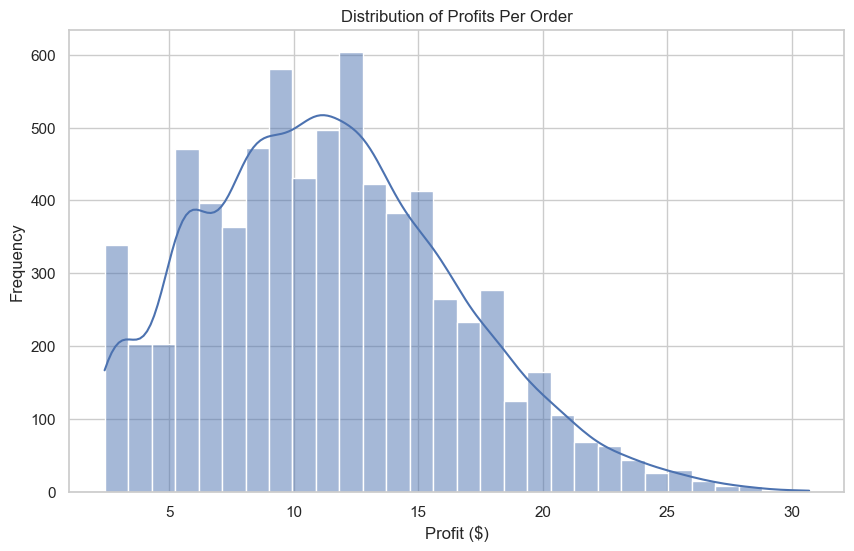

<Figure size 640x480 with 0 Axes>

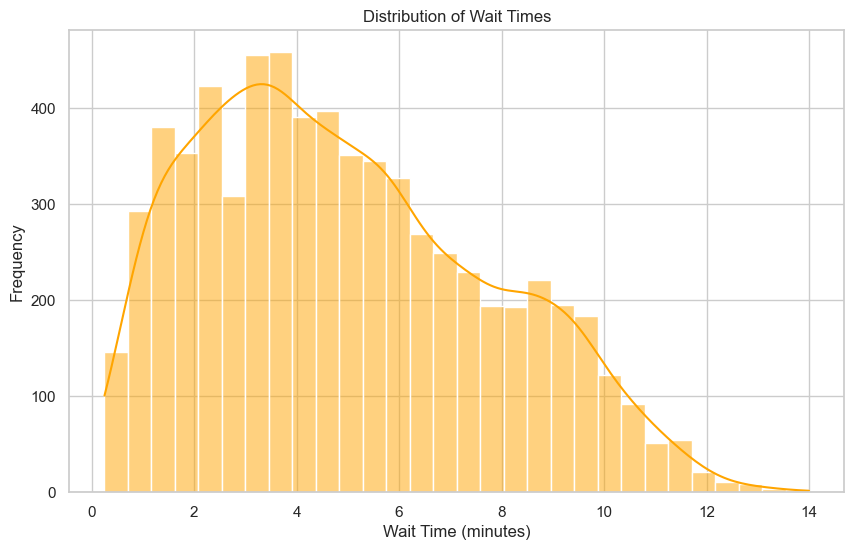

<Figure size 640x480 with 0 Axes>

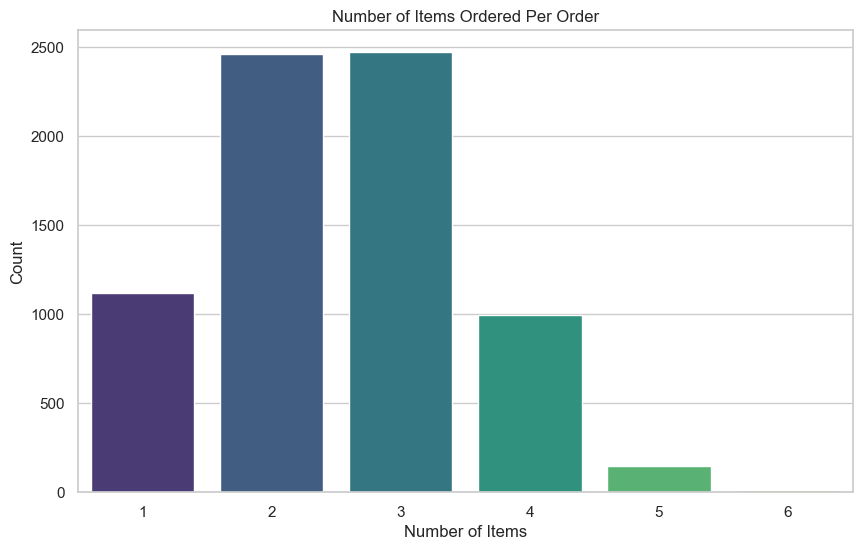

<Figure size 640x480 with 0 Axes>

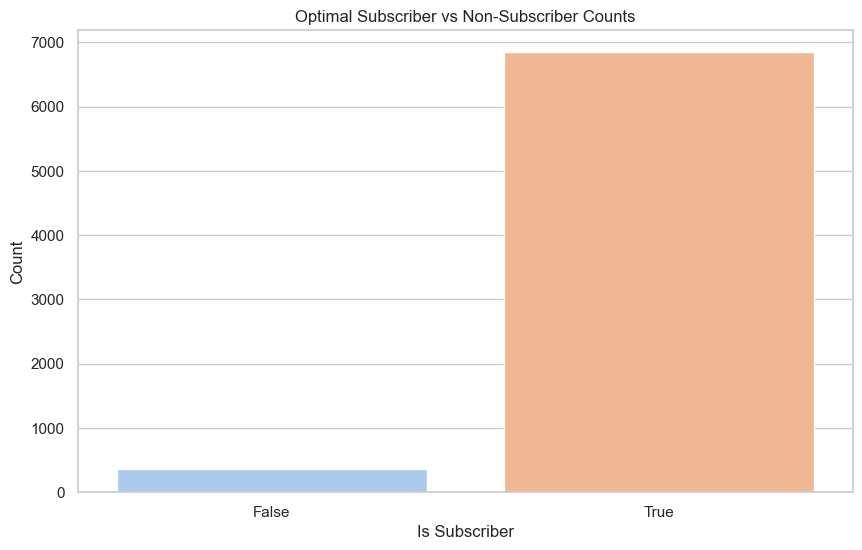

<Figure size 640x480 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setting plot style
sns.set(style="whitegrid")

# Plotting Profit Distribution
plt.figure(figsize=(10, 6))
sns.histplot(final_sim_df['profit'], bins=30, kde=True)
plt.title('Distribution of Profits Per Order')
plt.xlabel('Profit ($)')
plt.ylabel('Frequency')
plt.show()
plt.savefig('graphs/profit.png')

# Plotting Wait Time Distribution
plt.figure(figsize=(10, 6))
sns.histplot(final_sim_df['wait_time'], bins=30, kde=True, color='orange')
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')
plt.show()
plt.savefig('graphs/wait_time.png')


# Plotting Number of Items Ordered
plt.figure(figsize=(10, 6))
sns.countplot(x='num_items_ordered', data=final_sim_df, palette='viridis')
plt.title('Number of Items Ordered Per Order')
plt.xlabel('Number of Items')
plt.ylabel('Count')
plt.show()
plt.savefig('graphs/items_ordered.png')

# Subscriber vs Non-Subscriber Counts
plt.figure(figsize=(10, 6))
sns.countplot(x='is_subscriber', data=final_sim_df, palette='pastel')
plt.title('Optimal Subscriber vs Non-Subscriber Counts')
plt.xlabel('Is Subscriber')
plt.ylabel('Count')
plt.show()
plt.savefig('graphs/subscriber.png')

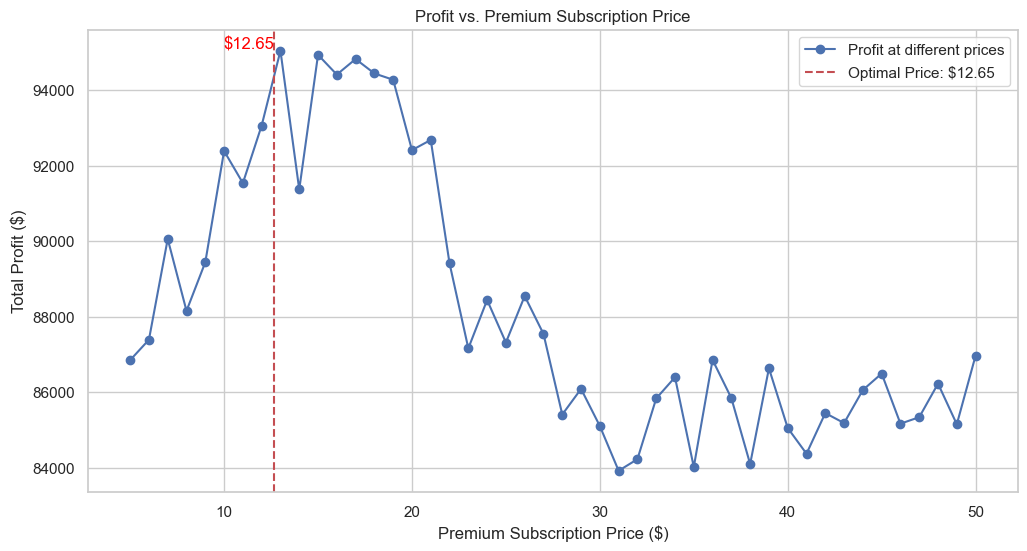

In [65]:
import matplotlib.pyplot as plt
optimal_price_index = optimal_price0
optimal_price = 12.65

plt.figure(figsize=(12, 6))
plt.plot(sim_df1['price'], sim_df1['profit'], marker='o', color='b', label='Profit at different prices')
plt.axvline(x=optimal_price, color='r', linestyle='--', label=f'Optimal Price: ${optimal_price}')
plt.text(optimal_price, max(profits), f'${optimal_price}', color='red', ha='right')
plt.xlabel('Premium Subscription Price ($)')
plt.ylabel('Total Profit ($)')
plt.title('Profit vs. Premium Subscription Price')
plt.legend()
plt.show()
plt.savefig('graphs/optimization.png')
